In [1]:
import utils
import pycascades_solver
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from ipywidgets import interact
from tigramite import data_processing, pcmci, plotting
from tigramite.independence_tests import robust_parcorr

# Detection Power for Simulations That Include Tipping

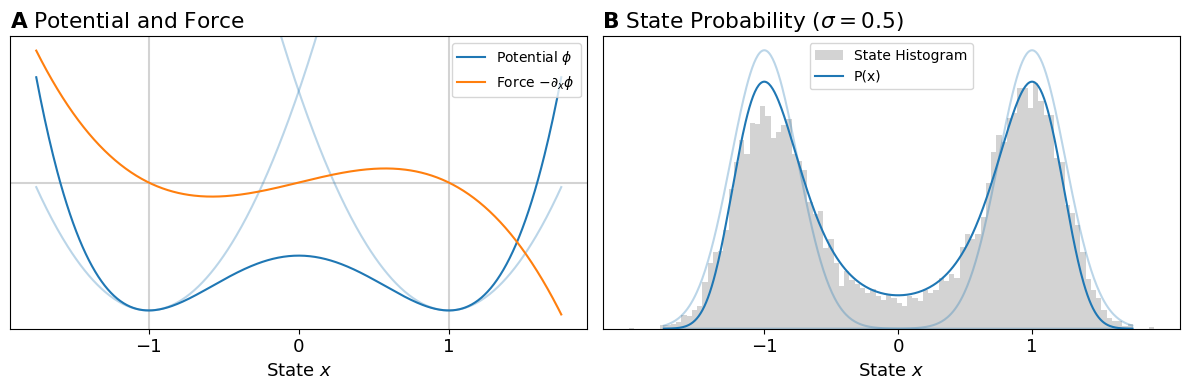

In [4]:
x  = np.linspace(-1.75, 1.75, 500)
dx = x[1] - x[0]
y = pycascades_solver.solve(0, np.zeros(1), 0.5, y0=0, tspan=np.arange(0, 1000, 0.1))

pot  = x**4/4 - x**2/2
dpot = x**3 - x

exp1 = (x - 1)**2
exp2 = (x + 1)**2

p = np.exp(-4*pot/(2*0.5**2))
p = p/(p.sum()*dx)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.axvline(-1, c="lightgray")
plt.axvline( 1, c="lightgray")
plt.axhline(0, c="lightgray")
plt.plot(x,  -2 + 6*pot, label=r"Potential $\phi$")
plt.plot(x,  -2 + 6*(0.25 - 0.5) + exp1*6, color="C0", alpha=0.3)
plt.plot(x,  -2 + 6*(0.25 - 0.5) + exp2*6, color="C0", alpha=0.3)
plt.plot(x, -dpot, c="C1", label=r"Force $-\partial_x \phi$")
plt.legend()
plt.ylim([-4.0, 4.0])
plt.xticks([-1, 0, 1])
plt.yticks([])
plt.xlabel(r"State $x$")
plt.title(r"$\bf{A}$ Potential and Force", x=0, ha="left")

p1 = np.exp(-4*exp1/(2*0.5**2))
p1 = p1/(p1.sum()*dx)
p2 = np.exp(-4*exp2/(2*0.5**2))
p2 = p2/(p2.sum()*dx)

plt.subplot(122)
plt.hist(y, bins=100, density=True, label="State Histogram", color="lightgray")
plt.plot(x, p, label=r"P(x)")
plt.plot(x, p1/2, c="C0", alpha=0.3)
plt.plot(x, p2/2, c="C0", alpha=0.3)
plt.legend()
plt.xticks([-1, 0, 1])
plt.yticks([])
plt.xlabel(r"State $x$")
plt.title(r"$\bf{B}$ State Probability ($\sigma = 0.5$)", x=0, ha="left")

plt.scale_font(1.3)
plt.tight_layout()
plt.savefig("../plots/fokker_planck_one_element.png", bbox_inches="tight", dpi=200)
plt.show()

## Binary Tipping Feedback

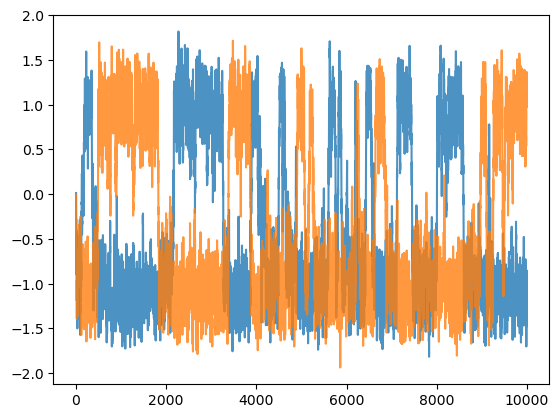

In [18]:
coupling_matrix = np.zeros((2, 2))
coupling_matrix[1, 0] = -0.2
coupling_matrix[0, 1] = -0.2

ysol  = pycascades_solver.solve(0, coupling_matrix, y0=[0,0], noise_level=0.5, tspan=np.arange(0, 1000, 0.1))
plt.plot(ysol, alpha=0.8)
plt.show()

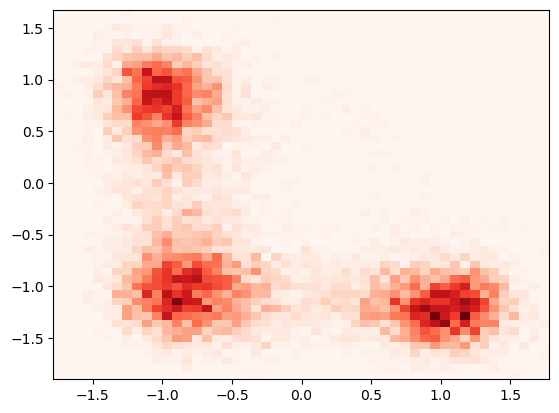

In [19]:
import pandas as pd

df = pd.DataFrame(ysol, columns=["x", "y"])
# calculate directional velocities and magnitude
df[["dx", "dy"]] = df.diff()
df["v"] = (df.dx**2 + df.dy**2)**0.5
# discretize x and y
df["xb"] = pd.cut(df.x, 50).apply(lambda x: x.mid)
df["yb"] = pd.cut(df.y, 50).apply(lambda x: x.mid)
df = df.dropna()

# calculate grid density and averages
dgrid = df.groupby(["xb", "yb"]).count().unstack().x.fillna(0)
grid  = df.groupby(["xb", "yb"]).mean().unstack()

#dgrid = sp.ndimage.gaussian_filter(dgrid, 1)

plt.imshow(dgrid, cmap="Reds", origin="lower", extent=(df.xb.min(), df.xb.max(), df.yb.min(), df.yb.max()), aspect="auto")
plt.show()

In [29]:
N  = 100
x  = np.linspace(-3, 3, N)
dx = x[1] - x[0]

k = np.zeros((2, 2))
k[0, 1] = -0.2
k[1, 0] = -0.2

x, y = np.meshgrid(x, x)
#p0 = sp.stats.norm.pdf(x, 0, 1)*sp.stats.norm.pdf(-y, 0, 1)
p0 = np.zeros_like(x)
p0[40:60,40:60] = 1
p0 = p0/(p0.sum()*dx**2)

vx = -x**3 + x + k[0, 1]*(y + 1)
vy = -y**3 + y + k[1, 0]*(x + 1) 

def dpdt(t, p):
    pnow = p.reshape((N, N))
    p = np.zeros_like(pnow)

    # mean reverting terms
    p -= np.gradient(vx*pnow, dx, axis=1) + np.gradient(vy*pnow, dx, axis=0)

    # diffusion terms
    p += 0.2**2/2*(np.gradient(np.gradient(pnow, dx, axis=0), dx, axis=0) + np.gradient(np.gradient(pnow, dx, axis=1), dx, axis=1))

    # boundary condition
    p[0,:] = p[:,0] = p[-1,:] = p[:,-1] = 0

    return p.flatten()

p = sp.integrate.solve_ivp(dpdt, y0=p0.flatten(), t_span=(0, 40), t_eval=np.linspace(0, 40, 1000)).y.reshape((N, N, -1))

ps = p[:,:,-1]
ps = ps/(ps.sum()*dx**2)

In [30]:
s = slice(4, 104,4)
m = (vx[s,s]**2 + vy[s,s]**2)**0.5

@interact(i=(0, p.shape[-1]-1, 1), field=["Full", "Coupling", "Self-Mechanics"])
def plot(i=0, field="Full"):
    plt.imshow(p[:,:,i], origin="lower", extent=(x.min(), x.max(), y.min(), y.max()), cmap="binary")

    if field=="Full":
        plt.quiver(x[s,s], y[s,s], vx[s,s]/m, vy[s,s]/m, angles="xy", color="red")
    if field=="Coupling":
        plt.quiver(x[s,s], y[s,s], k[0,1]*(y[s,s] + 1), k[1,0]*(x[s,s] + 1), angles="xy", color="blue")
    if field=="Self-Mechanics":
        plt.quiver(x[s,s], y[s,s], -x[s,s]**3 + x[s,s], -y[s,s]**3 + y[s,s], angles="xy", color="green")

interactive(children=(IntSlider(value=0, description='i', max=999), Dropdown(description='field', options=('Fu…

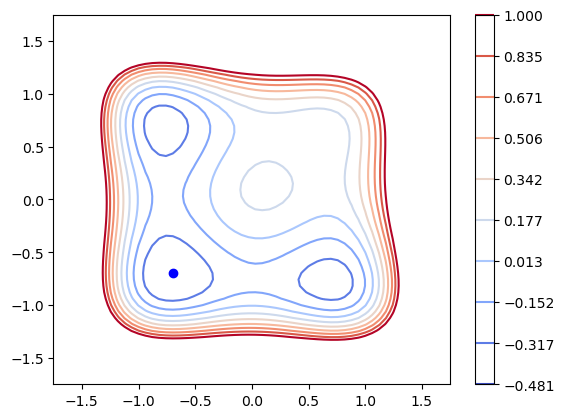

In [33]:
pot = x**4 - x**2 + y**4 - y**2 + 0.2*(x + 1)*(y + 1)
plt.scatter(x[pot == pot.min()].flatten(), y[pot == pot.min()].flatten(), c="blue")
plt.contour(x, y, pot, levels=np.linspace(np.min(pot), 1, 10), cmap="coolwarm")
plt.colorbar()
plt.xlim([-1.75, 1.75])
plt.ylim([-1.75, 1.75])
plt.show()

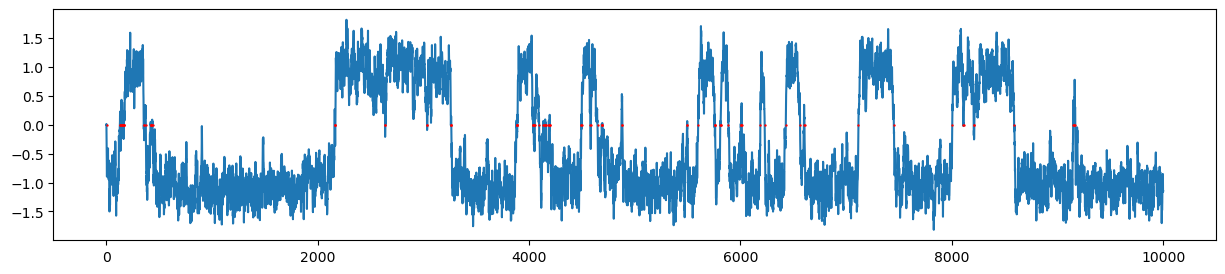

0.0099


In [23]:
ys = ysol[:,0]

a = []
for i in range(1, len(ys)):
    if ys[i - 1] > 0 and ys[i] < 0:
        a.append(i)
    if ys[i - 1] < 0 and ys[i] > 0:
        a.append(i)
a = np.array(a)

plt.figure(figsize=(15, 3)) 
plt.plot(ys)
plt.scatter(np.arange(len(ys))[a], np.zeros_like(a), c="red", zorder=99, s=0.5)
plt.show()

print(len(a)/len(ys))

In [24]:
x = np.linspace(-2, 2, 100)
dx = x[1] - x[0]
y = np.exp(-4*pot(x)/(2*0.5**2))
y = 2*y/(y.sum()*dx)
y = np.where(x > 0, y, 0)

plt.plot(x, y)
plt.hist(ys[np.argwhere(ys > 0)], density=True, bins=50)
plt.show()

w  = sp.stats.norm.pdf(x, 0, 0.5*0.1**0.5)
tp = sp.signal.convolve(y, w, mode="same")
tp = tp/(tp.sum()*dx)
plt.plot(x, tp)
i = np.argwhere(ys > 0).flatten() + 1
i = np.clip(i, 0, len(ys) - 1)
plt.hist(ys[i], density=True, bins=100)
plt.ylim([0, 0.4])
plt.show()

print(tp[x <= 0].sum()*dx)
print(np.sum(ys[i] < 0)/np.sum(ys > 0))

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
def mfpt(sigma, x0=-1, x1=1, pot=pot):
    
    def negint(x):
        return sp.integrate.quad(lambda a: np.exp(-pot(a)), -np.inf, x)[0]

    return 2/sigma**2 * abs(sp.integrate.quad(lambda a: np.exp(pot(a))*negint(a), x0, x1)[0])


def estimate_mfpt(y, x0=-1, x1=1, dt=0.1, tol=5e-2):
    posi = []
    taus = []
    for i in range(len(y)):
        if abs(y[i] - x0) < tol:
            posi.append(i)
        if abs(y[i] - x1) < tol and len(posi) > 0:
            [taus.append(i - tau) for tau in posi]
            posi = []

    return np.mean(taus)*dt/2 if len(taus) > 0 else np.nan

def tipping_time(y, dt=0.1, tol=5e-2):
    return 0.5*(estimate_mfpt(y, -1, 1, dt, tol) + estimate_mfpt(y, 1, -1, dt, tol))

In [ ]:
d = np.zeros((1, 1))
t = np.arange(0, 100000, 0.1)
sigma = np.linspace(0.5, 1, 10)
emfpt = [tipping_time(pycascades_solver.solve(0, d, s, y0=0, tspan=t)[:,0]) for s in sigma] 

In [ ]:
cmfpt = [mfpt(s) for s in sigma]
df = pd.DataFrame([sigma, cmfpt, emfpt]).T
df.columns = ["sigma", "mfpt", "mfpt_e"]
display(df)

,sigma,mfpt,mfpt_e
0,0.500000,27.906477,21.292423
1,0.555556,22.604247,14.480521
2,0.611111,18.681195,11.332203
3,0.666667,15.697393,9.155449
4,0.722222,13.375294,7.548727
5,0.777778,11.532779,6.549469
6,0.833333,10.046332,5.873853
7,0.888889,8.829784,5.330732
8,0.944444,7.821539,4.898303
9,1.000000,6.976619,4.491690


In [ ]:
(df.mfpt/df.mfpt_e).mean()

1.628417351041937

[]

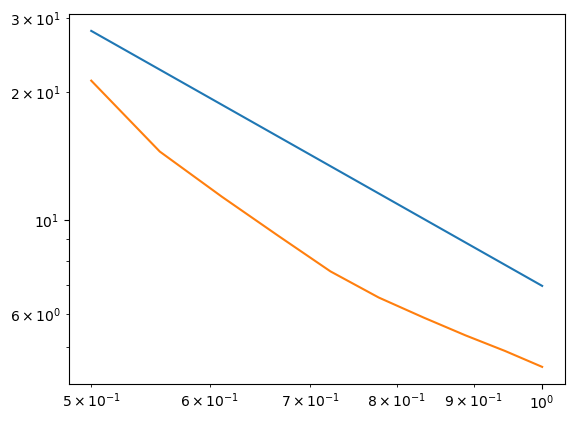

In [ ]:
plt.plot(df.sigma, df.mfpt)
plt.plot(df.sigma, df.mfpt_e)
plt.loglog()